In [5]:
import torch
import torchtext
import torchvision
import torchaudio

print(f"PyTorch version: {torch.__version__}")
print(f"Torchtext version: {torchtext.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Torchaudio version: {torchaudio.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version PyTorch compiled with: {torch.version.cuda}")
    print(f"Current CUDA driver version: {torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}") # Basic check

PyTorch version: 2.2.1+cu121
Torchtext version: 0.17.1+cpu
Torchvision version: 0.17.1+cu121
Torchaudio version: 2.2.1+cu121
CUDA available: True
CUDA version PyTorch compiled with: 12.1
Current CUDA driver version: 7.5


In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset # Changed to Dataset for more flexibility
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import os
from collections import Counter
from torchtext.vocab import vocab as build_vocab_from_iterator # Renamed

In [36]:
dataset_path = '/kaggle/input/tweepfakemsnew'
df = pd.read_csv(f'{dataset_path}/train.csv', delimiter=';')

# Set plotting style for thesis-quality figures
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

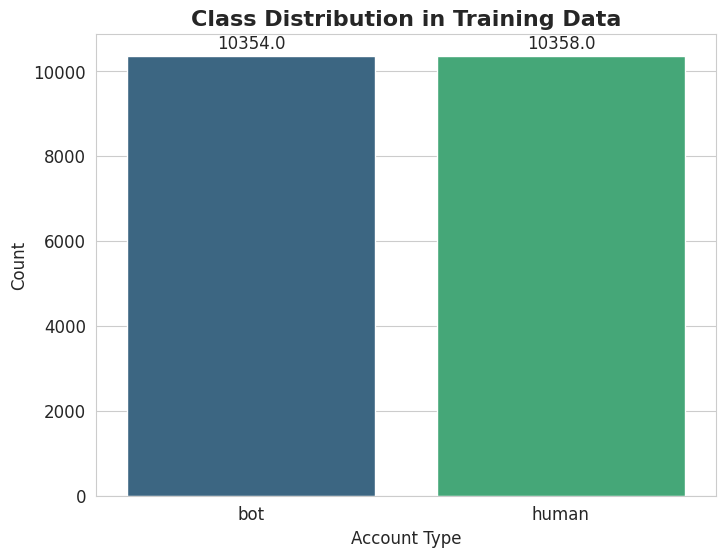

In [37]:
#1b. Class Distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='account.type', data=df, palette='viridis')
ax.set_title('Class Distribution in Training Data', fontsize=16, weight='bold')
ax.set_xlabel('Account Type', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')
#plt.savefig('eda_class_distribution.png')
plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


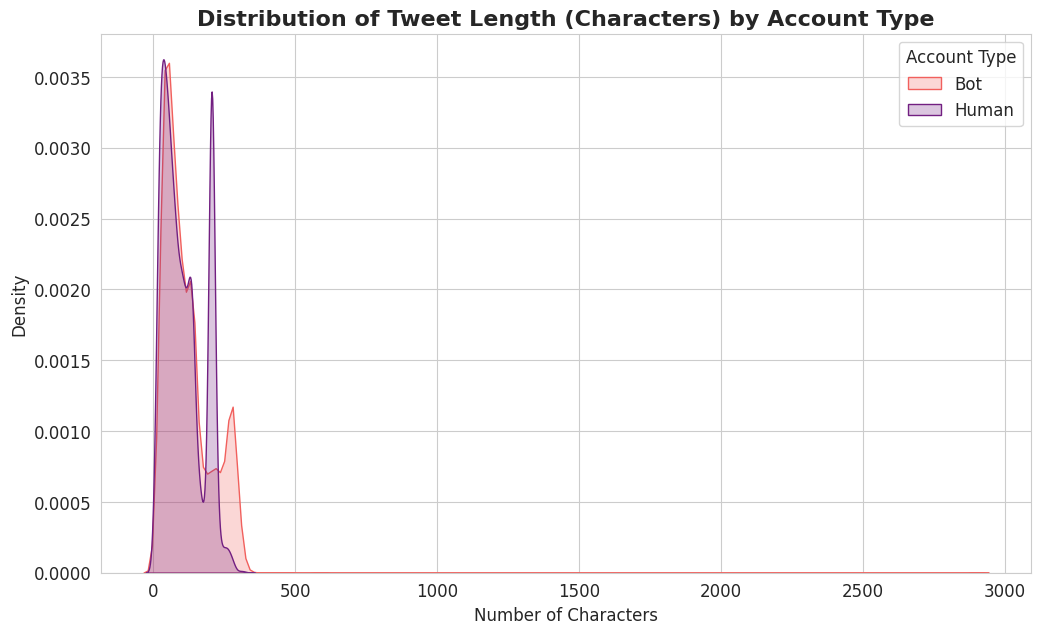

In [38]:
# 1c. Text Length Distribution
df['text_length'] = df['text'].str.len()

plt.figure(figsize=(12, 7))
sns.kdeplot(data=df, x='text_length', hue='account.type', fill=True, palette='magma')
plt.title('Distribution of Tweet Length (Characters) by Account Type', fontsize=16, weight='bold')
plt.xlabel('Number of Characters', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Account Type', labels=['Bot', 'Human'])
plt.savefig('eda_text_length_distribution.png')
plt.show()

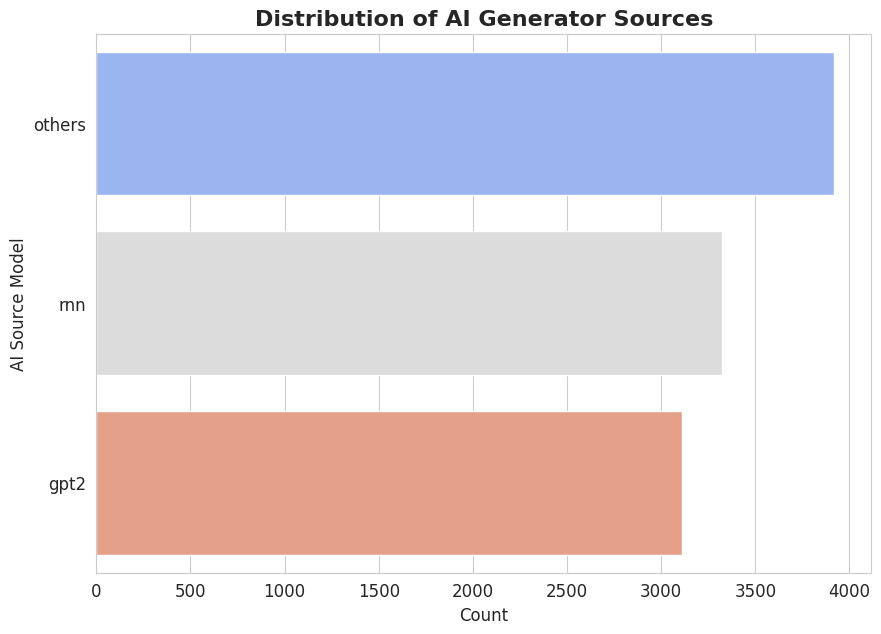

In [39]:
#1d. AI Generator Source Distribution (for Bot accounts)
df_bots = df[df['account.type'] == 'bot']

plt.figure(figsize=(10, 7))
ax = sns.countplot(y='class_type', data=df_bots, order=df_bots['class_type'].value_counts().index, palette='coolwarm')
ax.set_title('Distribution of AI Generator Sources', fontsize=16, weight='bold')
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('AI Source Model', fontsize=12)
#plt.savefig('eda_ai_source_distribution.png')
plt.show()

In [7]:
# --- 0. Configuration & Seeding ---
SEED = 42
MAX_LEN_LSTM = 100  # Max sequence length for LSTM input
BATCH_SIZE_LSTM = 64
EPOCHS_LSTM_ONLY = 10 # LSTMs might need more epochs
LEARNING_RATE_LSTM = 1e-3 # Typically higher for LSTMs from scratch
EMBEDDING_DIM = 100
HIDDEN_DIM_LSTM = 128
N_LAYERS_LSTM = 2
BIDIRECTIONAL_LSTM = True
DROPOUT_LSTM = 0.3
OUTPUT_DIR_LSTM = "./lstm_only_output"

if not os.path.exists(OUTPUT_DIR_LSTM):
    os.makedirs(OUTPUT_DIR_LSTM)

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

In [8]:
# --- 1. Device Setup ---
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Original
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Force GPU 0
print(f"Using specific device: {device}")

Using specific device: cuda:0


In [9]:
# --- 2. Load Data (Assuming df_train_orig, df_val_orig, df_test_orig are loaded) ---
dataset_path = '/kaggle/input/tweepfakemsnew'
df_train_orig = pd.read_csv(f'{dataset_path}/train.csv', delimiter=';')
df_val_orig = pd.read_csv(f'{dataset_path}/validation.csv', delimiter=';')
df_test_orig = pd.read_csv(f'{dataset_path}/test.csv', delimiter=';')

In [10]:
# --- 3. Text Cleaning for LSTM ---
def clean_text_for_lstm(text):
    text = str(text)
    text = re.sub(r'http\S+', ' <URL> ', text)
    text = re.sub(r'@\w+', ' <USER> ', text)
    text = re.sub(r'#\w+', ' <HASHTAG> ', text)
    text = re.sub(r'[^A-Za-z<> ]+', '', text) # Keep placeholders
    text = text.lower().strip()
    return text

In [11]:
df_train_orig['processed_text_lstm'] = df_train_orig['text'].apply(clean_text_for_lstm)
df_val_orig['processed_text_lstm'] = df_val_orig['text'].apply(clean_text_for_lstm)
df_test_orig['processed_text_lstm'] = df_test_orig['text'].apply(clean_text_for_lstm)


In [12]:
print(f"Original train samples: {len(df_train_orig)}")
empty_train_mask = df_train_orig['processed_text_lstm'].str.strip() == ""
print(f"Found {empty_train_mask.sum()} empty strings in train to remove.")
df_train_orig = df_train_orig[~empty_train_mask] # Keep rows where processed_text_lstm is NOT empty
print(f"Train samples after removing empty: {len(df_train_orig)}")

print(f"Original val samples: {len(df_val_orig)}")
empty_val_mask = df_val_orig['processed_text_lstm'].str.strip() == ""
print(f"Found {empty_val_mask.sum()} empty strings in val to remove.")
df_val_orig = df_val_orig[~empty_val_mask]
print(f"Val samples after removing empty: {len(df_val_orig)}")

# Test set has 0 empty strings, but for completeness and safety:
print(f"Original test samples: {len(df_test_orig)}")
empty_test_mask = df_test_orig['processed_text_lstm'].str.strip() == ""
print(f"Found {empty_test_mask.sum()} empty strings in test to remove.")
df_test_orig = df_test_orig[~empty_test_mask]
print(f"Test samples after removing empty: {len(df_test_orig)}")

# IMPORTANT: Reset index after filtering to ensure .iloc works as expected in your Dataset
df_train_orig.reset_index(drop=True, inplace=True)
df_val_orig.reset_index(drop=True, inplace=True)
df_test_orig.reset_index(drop=True, inplace=True)

print("Empty sequences removed and DataFrames re-indexed.")

# Now proceed with:
# 1. Building your vocabulary (torchtext_vocab_obj) using the filtered df_train_orig['processed_text_lstm']
# 2. Creating your TextDatasetLSTM instances using the filtered DataFrames
# 3. Creating DataLoaders
# 4. Training your model

Original train samples: 20712
Found 2 empty strings in train to remove.
Train samples after removing empty: 20710
Original val samples: 2302
Found 1 empty strings in val to remove.
Val samples after removing empty: 2301
Original test samples: 2558
Found 0 empty strings in test to remove.
Test samples after removing empty: 2558
Empty sequences removed and DataFrames re-indexed.


In [13]:
# --- 4. Label Encoding (if not already done in common setup) ---
label_mapping = {'human': 0, 'bot': 1}
num_labels_lstm = len(label_mapping)

df_train_orig['label_encoded'] = df_train_orig['account.type'].map(label_mapping)
df_val_orig['label_encoded'] = df_val_orig['account.type'].map(label_mapping)
df_test_orig['label_encoded'] = df_test_orig['account.type'].map(label_mapping)

In [14]:
from collections import Counter
from torchtext.vocab import build_vocab_from_iterator

# --- 5. Build Vocabulary (Focus on robust UNK usage) ---
def yield_tokens(data_iter):
    for text_entry in data_iter:
        yield str(text_entry).split()

print("Step 1: Preparing token iterator...")
token_iterator_for_builder = yield_tokens(df_train_orig['processed_text_lstm'])

specials_list = ["<unk>", "<pad>"] # <unk> is crucial
min_freq_threshold = 2

print("Step 2: Calling build_vocab_from_iterator...")
torchtext_vocab_obj = None
try:
    torchtext_vocab_obj = build_vocab_from_iterator(
        token_iterator_for_builder,
        min_freq=min_freq_threshold,
        specials=specials_list,
        special_first=True
    )
    print("build_vocab_from_iterator call successful.")
    
    # We will get UNK_IDX directly and use it in text_to_indices
    # No need to call set_default_index if we handle OOV explicitly in text_to_indices
    if "<unk>" not in torchtext_vocab_obj.get_stoi():
        print("CRITICAL ERROR: '<unk>' token is NOT in vocab.get_stoi(). OOV handling will fail.")
        # This should not happen with `specials_list` correctly passed.

except Exception as e:
    print(f"ERROR during build_vocab_from_iterator: {e}")


print("Step 3: Getting properties from Vocab object...")
if torchtext_vocab_obj is not None and hasattr(torchtext_vocab_obj, 'get_stoi'):
    VOCAB_SIZE = len(torchtext_vocab_obj)
    PAD_IDX = torchtext_vocab_obj.get_stoi().get('<pad>', -1)
    UNK_IDX = torchtext_vocab_obj.get_stoi().get('<unk>', -1) # Get the integer index for <unk>

    print(f"VOCAB_SIZE: {VOCAB_SIZE}")
    print(f"PAD_IDX: {PAD_IDX}")
    print(f"UNK_IDX (index of '<unk>'): {UNK_IDX}") # This must be a valid integer index

    if PAD_IDX == -1: print("ERROR: PAD_IDX is -1")
    if UNK_IDX == -1: print("ERROR: UNK_IDX is -1. '<unk>' token was not found in vocab's stoi.")

else:
    print("torchtext_vocab_obj is None or not a valid Vocab object.")
    # Halt or raise an error if vocab creation failed
    raise ValueError("Vocabulary creation failed. Cannot proceed with LSTM experiment.")



Step 1: Preparing token iterator...
Step 2: Calling build_vocab_from_iterator...
build_vocab_from_iterator call successful.
Step 3: Getting properties from Vocab object...
VOCAB_SIZE: 12077
PAD_IDX: 1
UNK_IDX (index of '<unk>'): 0


In [15]:
# --- 6.A Pre-Numericalize Texts ---
print("\nSection 6.A: Pre-numericalizing all datasets...")
# Ensure torchtext_vocab_obj, UNK_IDX are valid from Section 5
if 'torchtext_vocab_obj' not in locals() or torchtext_vocab_obj is None:
    raise NameError("torchtext_vocab_obj not defined. Run vocab building (Section 5) first.")
if 'UNK_IDX' not in locals() or not isinstance(UNK_IDX, int) or UNK_IDX < 0:
    raise ValueError(f"UNK_IDX is not a valid integer index ({UNK_IDX}). Run vocab building (Section 5) and check UNK_IDX.")

current_stoi_dict = torchtext_vocab_obj.get_stoi() # Get the string-to-index dictionary once

def numericalize_series_of_texts(texts_series, stoi_dict, max_len, unk_idx):
    all_numericalized_texts = []
    # Ensure texts_series is a pandas Series for .name attribute and tqdm compatibility
    series_name = texts_series.name if hasattr(texts_series, 'name') else 'texts'
    for text in tqdm(texts_series, desc=f"Numericalizing {series_name}"):
        tokens = str(text).strip().split()[:max_len]
        if not tokens: # Handle genuinely empty strings that might have slipped through filtering
                       # or if filtering was done on a different column
            tokens = ["<pad>"] # Use the PAD token; its index is PAD_IDX
                               # The stoi_dict.get will map "<pad>" to PAD_IDX
        indices = [stoi_dict.get(token, unk_idx) for token in tokens]
        all_numericalized_texts.append(torch.tensor(indices, dtype=torch.long))
    return all_numericalized_texts

# Use the 'processed_text_lstm' columns from your DataFrames
train_numericalized = numericalize_series_of_texts(df_train_orig['processed_text_lstm'], current_stoi_dict, MAX_LEN_LSTM, UNK_IDX)
val_numericalized = numericalize_series_of_texts(df_val_orig['processed_text_lstm'], current_stoi_dict, MAX_LEN_LSTM, UNK_IDX)
test_numericalized = numericalize_series_of_texts(df_test_orig['processed_text_lstm'], current_stoi_dict, MAX_LEN_LSTM, UNK_IDX)
print("All datasets pre-numericalized.")


# --- 7.A Custom Dataset Class for PRE-NUMERICALIZED LSTM Data ---
print("\nSection 7.A: Defining PretokenizedTextDatasetLSTM class...")
class PretokenizedTextDatasetLSTM(Dataset): # New Dataset class name
    def __init__(self, list_of_numericalized_text_tensors, labels_series):
        self.numericalized_texts = list_of_numericalized_text_tensors
        self.labels_np = labels_series.values # Convert pandas Series to NumPy array for faster access

    def __len__(self):
        return len(self.numericalized_texts)

    def __getitem__(self, idx):
        # Retrieve the pre-numericalized tensor and the label
        # No on-the-fly tokenization/numericalization here
        return self.numericalized_texts[idx], torch.tensor(self.labels_np[idx], dtype=torch.long)
print("PretokenizedTextDatasetLSTM class defined.")


Section 6.A: Pre-numericalizing all datasets...


Numericalizing processed_text_lstm:   0%|          | 0/20710 [00:00<?, ?it/s]

Numericalizing processed_text_lstm:   0%|          | 0/2301 [00:00<?, ?it/s]

Numericalizing processed_text_lstm:   0%|          | 0/2558 [00:00<?, ?it/s]

All datasets pre-numericalized.

Section 7.A: Defining PretokenizedTextDatasetLSTM class...
PretokenizedTextDatasetLSTM class defined.


In [16]:
# --- Corrected instantiation of TextDatasetLSTM (should be part of your Section 7 or where you define datasets) ---
print("\nCreating LSTM datasets with explicit UNK_IDX...")

# Ensure torchtext_vocab_obj and UNK_IDX are defined and valid from Section 5
if 'torchtext_vocab_obj' not in locals() or torchtext_vocab_obj is None:
    raise NameError("torchtext_vocab_obj is not defined. Please run vocabulary building cell (Section 5).")
if 'UNK_IDX' not in locals() or not isinstance(UNK_IDX, int) or UNK_IDX < 0:
    # Attempt to re-fetch UNK_IDX as a fallback, but ideally it's set correctly in Section 5
    print("Warning: UNK_IDX not properly defined or invalid. Attempting to re-fetch from torchtext_vocab_obj...")
    if "<unk>" in torchtext_vocab_obj.get_stoi():
        UNK_IDX = torchtext_vocab_obj.get_stoi()["<unk>"]
        print(f"Re-fetched UNK_IDX: {UNK_IDX}")
    else:
        raise ValueError("'<unk>' token not found in vocabulary STOI map. UNK_IDX is invalid.")
    if not isinstance(UNK_IDX, int) or UNK_IDX < 0:
         raise ValueError(f"UNK_IDX is still invalid after re-fetch: {UNK_IDX}. Check vocab building.")


print(f"Using torchtext_vocab_obj (type: {type(torchtext_vocab_obj)}) and UNK_IDX: {UNK_IDX} for TextDatasetLSTM")

# --- Create PRE-NUMERICALIZED datasets (using the new Dataset class) ---
print("\nCreating pre-numericalized LSTM datasets...")
train_dataset_lstm = PretokenizedTextDatasetLSTM(train_numericalized, df_train_orig['label_encoded'])
val_dataset_lstm = PretokenizedTextDatasetLSTM(val_numericalized, df_val_orig['label_encoded'])
test_dataset_lstm = PretokenizedTextDatasetLSTM(test_numericalized, df_test_orig['label_encoded'])
print("Pre-numericalized LSTM datasets created.")


Creating LSTM datasets with explicit UNK_IDX...
Using torchtext_vocab_obj (type: <class 'torchtext.vocab.vocab.Vocab'>) and UNK_IDX: 0 for TextDatasetLSTM

Creating pre-numericalized LSTM datasets...
Pre-numericalized LSTM datasets created.


In [17]:
# --- 8. Collate Function for Padding ---
print("\nSection 8: Defining collate_batch_lstm_prenumericalized function...")
# Ensure PAD_IDX is a valid integer index from your vocabulary (Section 5)
if 'PAD_IDX' not in locals() or not isinstance(PAD_IDX, int) or PAD_IDX < 0:
    raise ValueError(f"PAD_IDX is not a valid integer index ({PAD_IDX}). Run vocab building (Section 5) and check PAD_IDX.")

def collate_batch_lstm_prenumericalized(batch): # Can keep your original name or rename
    label_list, text_indices_list, length_list = [], [], []
    for (_text_indices_tensor, _label_tensor) in batch:
        label_list.append(_label_tensor)
        text_indices_list.append(_text_indices_tensor)
        length_list.append(len(_text_indices_tensor))

    padded_texts = pad_sequence(text_indices_list, padding_value=PAD_IDX, batch_first=True) # Use PAD_IDX

    if padded_texts.size(1) < MAX_LEN_LSTM: # Optional: pad to global MAX_LEN_LSTM
        padding_tensor = torch.full(
            (padded_texts.size(0), MAX_LEN_LSTM - padded_texts.size(1)),
            PAD_IDX, dtype=padded_texts.dtype
        )
        padded_texts = torch.cat([padded_texts, padding_tensor], dim=1)
    
    return padded_texts, torch.tensor(label_list, dtype=torch.long), torch.tensor(length_list, dtype=torch.int64)
print("collate_batch_lstm_prenumericalized function defined.")


Section 8: Defining collate_batch_lstm_prenumericalized function...
collate_batch_lstm_prenumericalized function defined.


In [18]:
# --- 9. DataLoaders ---
print("\nSection 9: Creating DataLoaders for pre-numericalized data...")
train_dataloader_lstm = DataLoader(
    train_dataset_lstm, # Uses PretokenizedTextDatasetLSTM
    batch_size=BATCH_SIZE_LSTM,
    shuffle=True,
    collate_fn=collate_batch_lstm_prenumericalized, # Use the correct collate function
    num_workers=0 # Start with 0 to test this change
)
# ... similar for val_dataloader_lstm and test_dataloader_lstm ...
val_dataloader_lstm = DataLoader(val_dataset_lstm, batch_size=BATCH_SIZE_LSTM, shuffle=False, collate_fn=collate_batch_lstm_prenumericalized, num_workers=0)
test_dataloader_lstm = DataLoader(test_dataset_lstm, batch_size=BATCH_SIZE_LSTM, shuffle=False, collate_fn=collate_batch_lstm_prenumericalized, num_workers=0)
print("DataLoaders created.")


Section 9: Creating DataLoaders for pre-numericalized data...
DataLoaders created.


In [19]:
class LSTMOnlyClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            dropout=dropout if n_layers > 1 else 0,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text_indices, text_lengths): # Ensure text_lengths is passed
        embedded = self.dropout(self.embedding(text_indices))
        # embedded: [batch_size, seq_len, emb_dim]

        # Pack sequence: text_lengths must be on CPU for pack_padded_sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)

        # Process packed sequence with LSTM
        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        # We only need the final hidden state for classification.
        # Unpacking the output sequence (lstm_out) is not strictly necessary here
        # if you only use the 'hidden' state for the classifier.
        # If you needed lstm_out for e.g. attention, you'd unpack:
        # lstm_out, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True, total_length=MAX_LEN_LSTM)

        if self.lstm.bidirectional:
            # Concatenate the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden states
            hidden_combined = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden_combined = self.dropout(hidden[-1,:,:])
        # hidden_combined: [batch_size, hidden_dim * num_directions]

        logits = self.fc(hidden_combined)
        return {"logits": logits}

In [20]:
model_lstm_only = LSTMOnlyClassifier(VOCAB_SIZE,
                                     EMBEDDING_DIM,
                                     HIDDEN_DIM_LSTM,
                                     num_labels_lstm, # Output dim is num_labels
                                     N_LAYERS_LSTM,
                                     BIDIRECTIONAL_LSTM,
                                     DROPOUT_LSTM,
                                     PAD_IDX).to(device)

In [21]:
from torch.optim import AdamW

In [22]:
# --- 11. Optimizer and Criterion ---
optimizer_lstm_only = AdamW(model_lstm_only.parameters(), lr=LEARNING_RATE_LSTM)
criterion_lstm_only = nn.CrossEntropyLoss() # Loss will be calculated in the training loop

In [23]:
def train_model_lstm_only(model, train_loader, val_loader, optimizer, criterion, device, epochs, model_save_path_base):
    best_val_f1 = 0.0
    best_model_path = ""

    # Lists to store history
    history = {
        'epoch': [],
        'train_avg_loss': [],
        'val_avg_loss': [],
        'val_f1_score': [],
        'val_accuracy': []
    }

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} [Train]", leave=False)

        for text_indices, labels, text_lengths in train_progress_bar:
            optimizer.zero_grad()
            text_indices = text_indices.to(device)
            labels = labels.to(device)
            text_lengths = text_lengths.to(device) # Assuming you pass this

            outputs = model(text_indices, text_lengths) # Pass text_lengths if your model uses it
            logits = outputs["logits"]
            loss = criterion(logits, labels)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            train_progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Epoch {epoch + 1} - Train Avg Loss: {avg_train_loss:.4f}")

        # Validation
        # Ensure evaluate_model_lstm_only returns accuracy, f1, and avg_loss
        val_accuracy, val_f1, avg_val_loss = evaluate_model_lstm_only(
            model, val_loader, criterion, device, f"Validation Epoch {epoch+1}"
        )

        # Store history
        history['epoch'].append(epoch + 1)
        history['train_avg_loss'].append(avg_train_loss)
        history['val_avg_loss'].append(avg_val_loss)
        history['val_f1_score'].append(val_f1)
        history['val_accuracy'].append(val_accuracy)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_path = os.path.join(OUTPUT_DIR_LSTM, f"{model_save_path_base}_epoch{epoch+1}_f1_{val_f1:.4f}.pt")
            torch.save(model.state_dict(), best_model_path)
            print(f"New best validation F1: {best_val_f1:.4f}. Model saved to {best_model_path}")

    print(f"Training complete. Best validation F1: {best_val_f1:.4f} achieved at {best_model_path}")
    
    # Convert history to DataFrame for easy viewing/plotting
    history_df = pd.DataFrame(history)
    
    return best_model_path, history_df # Return the history DataFrame

In [24]:
# --- 13. Evaluation Function for LSTM-Only ---
def evaluate_model_lstm_only(model, dataloader, criterion, device, dataset_name="Dataset"): # Added criterion
    model.eval()
    all_preds = []
    all_labels = []
    total_eval_loss = 0

    with torch.no_grad():
        eval_progress_bar = tqdm(dataloader, desc=f"Evaluating on {dataset_name}", leave=False)
        for text_indices, labels, text_lengths in eval_progress_bar: # text_lengths is unpacked
            text_indices = text_indices.to(device)
            labels = labels.to(device)
            text_lengths = text_lengths.to(device) # Move to device

            # Pass text_lengths to the model
            outputs = model(text_indices, text_lengths) # MODIFIED CALL
            logits = outputs["logits"]
            loss = criterion(logits, labels) # Calculate loss using passed criterion
            total_eval_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    # ... (rest of the evaluation loop: printing metrics, confusion matrix) ...
    avg_eval_loss = total_eval_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")

    print(f"\n--- {dataset_name} Results ---")
    print(f"Avg Loss: {avg_eval_loss:.4f}") # Now you can print avg eval loss
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")
    print(classification_report(all_labels, all_preds, target_names=label_mapping.keys()))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.show()

    return accuracy, f1, avg_eval_loss

Epoch 1/10 [Train]:   0%|          | 0/324 [00:00<?, ?it/s]

Epoch 1 - Train Avg Loss: 0.4418


Evaluating on Validation Epoch 1:   0%|          | 0/36 [00:00<?, ?it/s]


--- Validation Epoch 1 Results ---
Avg Loss: 0.4116
Accuracy: 0.7966
F1-Score (Weighted): 0.7948
              precision    recall  f1-score   support

       human       0.86      0.70      0.78      1149
         bot       0.75      0.89      0.81      1152

    accuracy                           0.80      2301
   macro avg       0.81      0.80      0.79      2301
weighted avg       0.81      0.80      0.79      2301



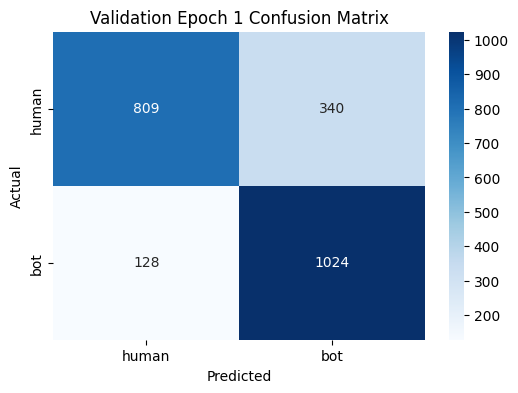

New best validation F1: 0.7948. Model saved to ./lstm_only_output/lstm_only_epoch1_f1_0.7948.pt


Epoch 2/10 [Train]:   0%|          | 0/324 [00:00<?, ?it/s]

Epoch 2 - Train Avg Loss: 0.3831


Evaluating on Validation Epoch 2:   0%|          | 0/36 [00:00<?, ?it/s]


--- Validation Epoch 2 Results ---
Avg Loss: 0.3982
Accuracy: 0.8092
F1-Score (Weighted): 0.8084
              precision    recall  f1-score   support

       human       0.86      0.74      0.80      1149
         bot       0.77      0.88      0.82      1152

    accuracy                           0.81      2301
   macro avg       0.81      0.81      0.81      2301
weighted avg       0.81      0.81      0.81      2301



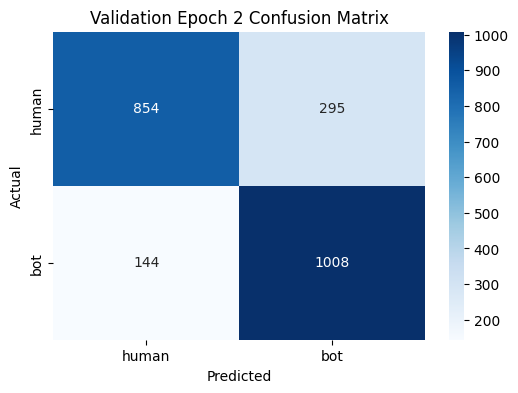

New best validation F1: 0.8084. Model saved to ./lstm_only_output/lstm_only_epoch2_f1_0.8084.pt


Epoch 3/10 [Train]:   0%|          | 0/324 [00:00<?, ?it/s]

Epoch 3 - Train Avg Loss: 0.3476


Evaluating on Validation Epoch 3:   0%|          | 0/36 [00:00<?, ?it/s]


--- Validation Epoch 3 Results ---
Avg Loss: 0.3920
Accuracy: 0.8149
F1-Score (Weighted): 0.8130
              precision    recall  f1-score   support

       human       0.89      0.72      0.79      1149
         bot       0.76      0.91      0.83      1152

    accuracy                           0.81      2301
   macro avg       0.83      0.81      0.81      2301
weighted avg       0.83      0.81      0.81      2301



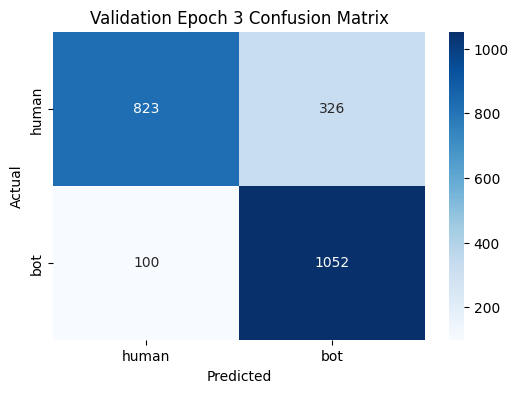

New best validation F1: 0.8130. Model saved to ./lstm_only_output/lstm_only_epoch3_f1_0.8130.pt


Epoch 4/10 [Train]:   0%|          | 0/324 [00:00<?, ?it/s]

Epoch 4 - Train Avg Loss: 0.3185


Evaluating on Validation Epoch 4:   0%|          | 0/36 [00:00<?, ?it/s]


--- Validation Epoch 4 Results ---
Avg Loss: 0.4027
Accuracy: 0.8070
F1-Score (Weighted): 0.8065
              precision    recall  f1-score   support

       human       0.84      0.75      0.80      1149
         bot       0.78      0.86      0.82      1152

    accuracy                           0.81      2301
   macro avg       0.81      0.81      0.81      2301
weighted avg       0.81      0.81      0.81      2301



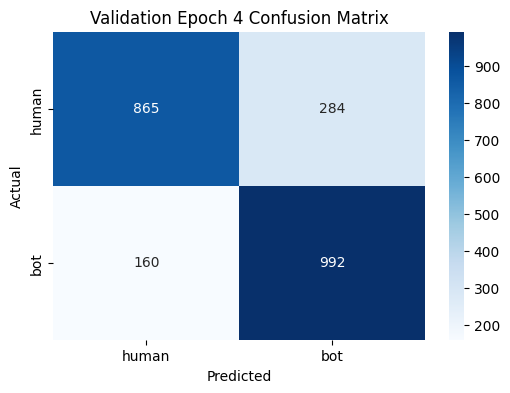

Epoch 5/10 [Train]:   0%|          | 0/324 [00:00<?, ?it/s]

Epoch 5 - Train Avg Loss: 0.2860


Evaluating on Validation Epoch 5:   0%|          | 0/36 [00:00<?, ?it/s]


--- Validation Epoch 5 Results ---
Avg Loss: 0.4576
Accuracy: 0.8092
F1-Score (Weighted): 0.8080
              precision    recall  f1-score   support

       human       0.87      0.73      0.79      1149
         bot       0.77      0.89      0.82      1152

    accuracy                           0.81      2301
   macro avg       0.82      0.81      0.81      2301
weighted avg       0.82      0.81      0.81      2301



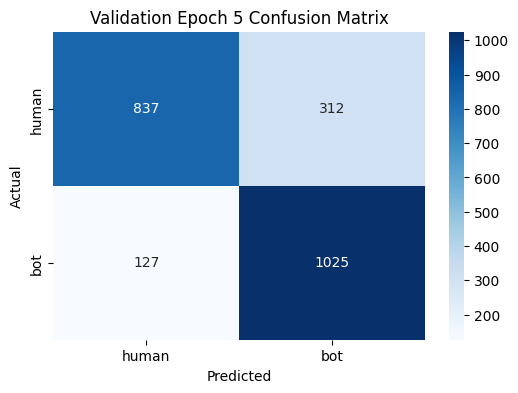

Epoch 6/10 [Train]:   0%|          | 0/324 [00:00<?, ?it/s]

Epoch 6 - Train Avg Loss: 0.2539


Evaluating on Validation Epoch 6:   0%|          | 0/36 [00:00<?, ?it/s]


--- Validation Epoch 6 Results ---
Avg Loss: 0.4482
Accuracy: 0.8079
F1-Score (Weighted): 0.8072
              precision    recall  f1-score   support

       human       0.85      0.75      0.80      1149
         bot       0.78      0.87      0.82      1152

    accuracy                           0.81      2301
   macro avg       0.81      0.81      0.81      2301
weighted avg       0.81      0.81      0.81      2301



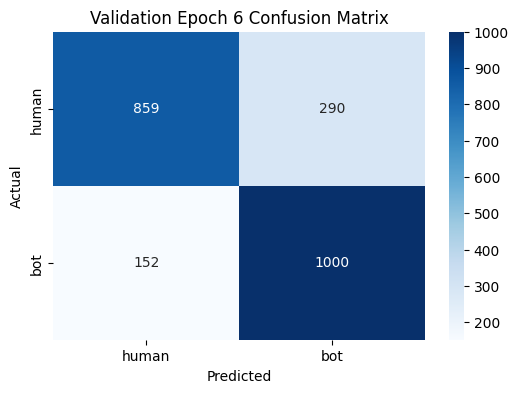

Epoch 7/10 [Train]:   0%|          | 0/324 [00:00<?, ?it/s]

Epoch 7 - Train Avg Loss: 0.2256


Evaluating on Validation Epoch 7:   0%|          | 0/36 [00:00<?, ?it/s]


--- Validation Epoch 7 Results ---
Avg Loss: 0.4509
Accuracy: 0.8123
F1-Score (Weighted): 0.8121
              precision    recall  f1-score   support

       human       0.83      0.78      0.81      1149
         bot       0.80      0.84      0.82      1152

    accuracy                           0.81      2301
   macro avg       0.81      0.81      0.81      2301
weighted avg       0.81      0.81      0.81      2301



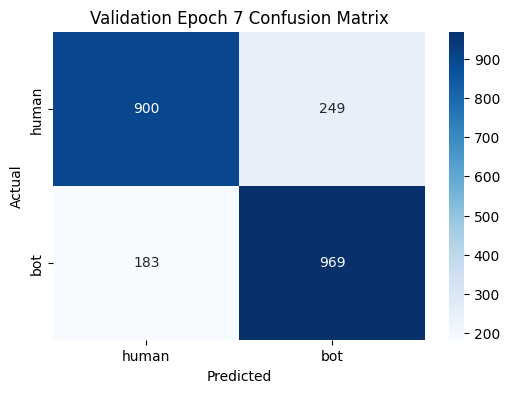

Epoch 8/10 [Train]:   0%|          | 0/324 [00:00<?, ?it/s]

Epoch 8 - Train Avg Loss: 0.1935


Evaluating on Validation Epoch 8:   0%|          | 0/36 [00:00<?, ?it/s]


--- Validation Epoch 8 Results ---
Avg Loss: 0.4877
Accuracy: 0.8175
F1-Score (Weighted): 0.8169
              precision    recall  f1-score   support

       human       0.86      0.76      0.81      1149
         bot       0.79      0.87      0.83      1152

    accuracy                           0.82      2301
   macro avg       0.82      0.82      0.82      2301
weighted avg       0.82      0.82      0.82      2301



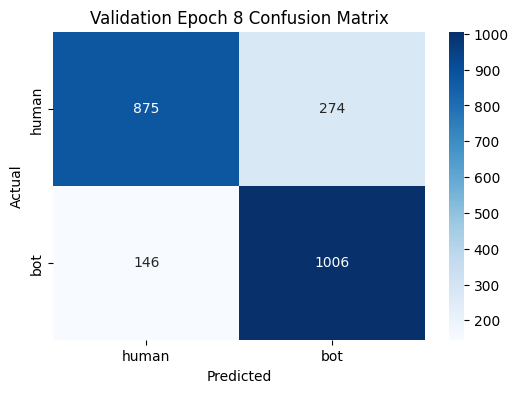

New best validation F1: 0.8169. Model saved to ./lstm_only_output/lstm_only_epoch8_f1_0.8169.pt


Epoch 9/10 [Train]:   0%|          | 0/324 [00:00<?, ?it/s]

Epoch 9 - Train Avg Loss: 0.1663


Evaluating on Validation Epoch 9:   0%|          | 0/36 [00:00<?, ?it/s]


--- Validation Epoch 9 Results ---
Avg Loss: 0.5236
Accuracy: 0.8105
F1-Score (Weighted): 0.8103
              precision    recall  f1-score   support

       human       0.83      0.77      0.80      1149
         bot       0.79      0.85      0.82      1152

    accuracy                           0.81      2301
   macro avg       0.81      0.81      0.81      2301
weighted avg       0.81      0.81      0.81      2301



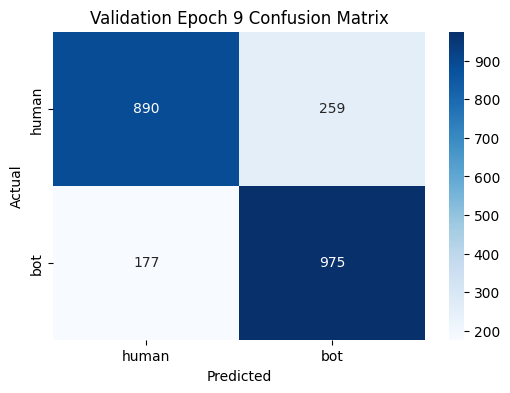

Epoch 10/10 [Train]:   0%|          | 0/324 [00:00<?, ?it/s]

Epoch 10 - Train Avg Loss: 0.1402


Evaluating on Validation Epoch 10:   0%|          | 0/36 [00:00<?, ?it/s]


--- Validation Epoch 10 Results ---
Avg Loss: 0.5537
Accuracy: 0.8153
F1-Score (Weighted): 0.8151
              precision    recall  f1-score   support

       human       0.83      0.79      0.81      1149
         bot       0.80      0.84      0.82      1152

    accuracy                           0.82      2301
   macro avg       0.82      0.82      0.82      2301
weighted avg       0.82      0.82      0.82      2301



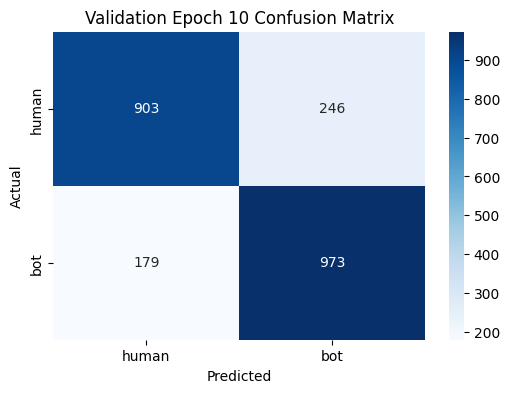

Training complete. Best validation F1: 0.8169 achieved at ./lstm_only_output/lstm_only_epoch8_f1_0.8169.pt


In [25]:
best_lstm_only_model_path, lstm_training_history_df = train_model_lstm_only(
    model_lstm_only,
    train_dataloader_lstm,
    val_dataloader_lstm,
    optimizer_lstm_only,
    criterion_lstm_only,
    device,
    epochs=EPOCHS_LSTM_ONLY,
    model_save_path_base="lstm_only"
)


LSTM Training History DataFrame:
   epoch  train_avg_loss  val_avg_loss  val_f1_score  val_accuracy
0      1        0.441827      0.411557      0.794844      0.796610
1      2        0.383141      0.398200      0.808372      0.809213
2      3        0.347589      0.392034      0.813035      0.814863
3      4        0.318522      0.402681      0.806465      0.807040
4      5        0.286040      0.457639      0.807952      0.809213
5      6        0.253904      0.448198      0.807201      0.807910
6      7        0.225629      0.450905      0.812094      0.812256
7      8        0.193487      0.487663      0.816891      0.817471
8      9        0.166346      0.523579      0.810267      0.810517
9     10        0.140244      0.553688      0.815134      0.815298


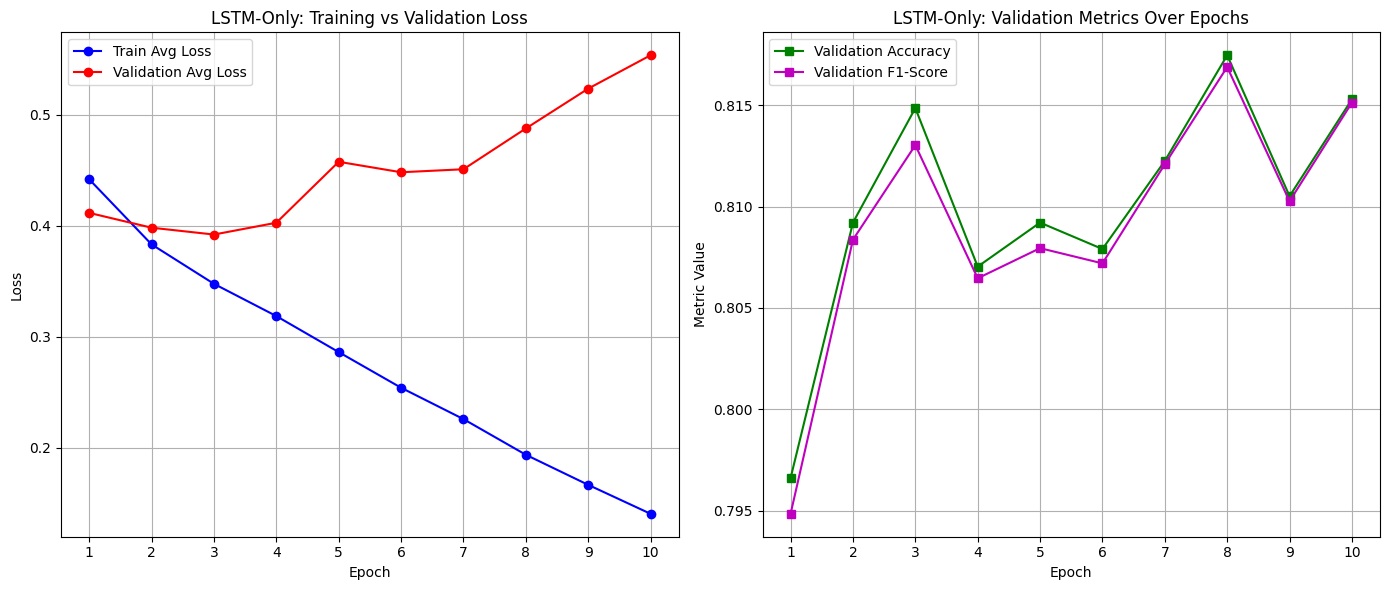

In [26]:
print("\nLSTM Training History DataFrame:")
print(lstm_training_history_df)

# And to generate the plots (which are very helpful for seeing overfitting):
import matplotlib.pyplot as plt
import pandas as pd # Should already be imported, but good practice

if 'lstm_training_history_df' in locals() and isinstance(lstm_training_history_df, pd.DataFrame):
    plt.figure(figsize=(14, 6))

    # Plotting Training vs Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(lstm_training_history_df['epoch'], lstm_training_history_df['train_avg_loss'], 'bo-', label='Train Avg Loss')
    plt.plot(lstm_training_history_df['epoch'], lstm_training_history_df['val_avg_loss'], 'ro-', label='Validation Avg Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('LSTM-Only: Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    # Ensure all epoch numbers are shown as ticks if there aren't too many
    if len(lstm_training_history_df['epoch']) <= 20 : # Adjust threshold as needed
        plt.xticks(lstm_training_history_df['epoch'])


    # Plotting Validation Metrics
    plt.subplot(1, 2, 2)
    plt.plot(lstm_training_history_df['epoch'], lstm_training_history_df['val_accuracy'], 'gs-', label='Validation Accuracy')
    plt.plot(lstm_training_history_df['epoch'], lstm_training_history_df['val_f1_score'], 'ms-', label='Validation F1-Score')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.title('LSTM-Only: Validation Metrics Over Epochs')
    plt.legend()
    plt.grid(True)
    if len(lstm_training_history_df['epoch']) <= 20 : # Adjust threshold as needed
        plt.xticks(lstm_training_history_df['epoch'])


    plt.tight_layout()
    plt.show()
else:
    print("DataFrame 'lstm_training_history_df' not found or is not a DataFrame.")
    print("Please ensure the training cell that defines it has completed successfully.")

In [27]:

if best_lstm_only_model_path and os.path.exists(best_lstm_only_model_path):
    print(f"\nLoading best LSTM-Only model from: {best_lstm_only_model_path}")
    model_lstm_only.load_state_dict(torch.load(best_lstm_only_model_path))
else:
    print("No best model for LSTM-Only was saved. Evaluating with the last state.")


Loading best LSTM-Only model from: ./lstm_only_output/lstm_only_epoch8_f1_0.8169.pt



--- Testing LSTM-Only on Test Set (with best model) ---


Evaluating on LSTM-Only Test:   0%|          | 0/40 [00:00<?, ?it/s]


--- LSTM-Only Test Results ---
Avg Loss: 0.4676
Accuracy: 0.8256
F1-Score (Weighted): 0.8251
              precision    recall  f1-score   support

       human       0.86      0.77      0.82      1278
         bot       0.79      0.88      0.83      1280

    accuracy                           0.83      2558
   macro avg       0.83      0.83      0.83      2558
weighted avg       0.83      0.83      0.83      2558



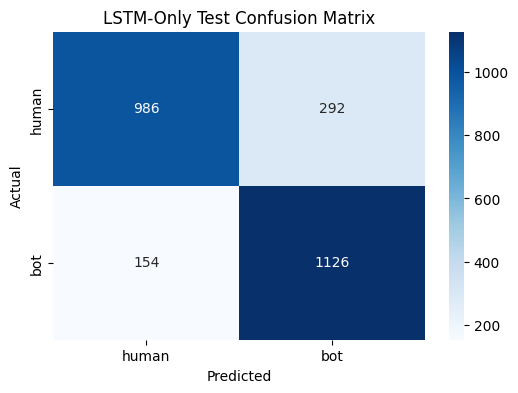

In [28]:
print("\n--- Testing LSTM-Only on Test Set (with best model) ---")
test_acc_lstm_only, test_f1_lstm_only, test_loss_lstm_only = evaluate_model_lstm_only(
    model_lstm_only,
    test_dataloader_lstm,
    criterion_lstm_only,
    device,
    "LSTM-Only Test"
)

In [29]:
print(f"LSTM-Only Test Set - Accuracy: {test_acc_lstm_only:.4f}, F1: {test_f1_lstm_only:.4f}, Loss: {test_loss_lstm_only:.4f}")

del model_lstm_only, optimizer_lstm_only, train_dataloader_lstm, val_dataloader_lstm, test_dataloader_lstm
torch.cuda.empty_cache()

LSTM-Only Test Set - Accuracy: 0.8256, F1: 0.8251, Loss: 0.4676


In [30]:
# --- SECTION: Post-Training Analysis for LSTM-Only Model ---
# !pip install lime

import torch
import joblib # Using joblib to save the vocab object
import os

# --- 1. Save the torchtext vocabulary object ---
# This is crucial for being able to use the model on new text later.
vocab_path = os.path.join(OUTPUT_DIR_LSTM, "torchtext_vocab.pkl")
print(f"Saving torchtext vocabulary to: {vocab_path}")
joblib.dump(torchtext_vocab_obj, vocab_path)


# --- 2. Load the Best Model ---
# The best model path is already stored in the 'best_lstm_only_model_path' variable.
if 'best_lstm_only_model_path' in locals() and best_lstm_only_model_path and os.path.exists(best_lstm_only_model_path):
    print(f"Loading best model from: {best_lstm_only_model_path}")
    # Re-instantiate the model architecture
    loaded_model_lstm = LSTMOnlyClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM_LSTM, num_labels_lstm, 
                                           N_LAYERS_LSTM, BIDIRECTIONAL_LSTM, DROPOUT_LSTM, PAD_IDX)
    # Load the saved weights
    loaded_model_lstm.load_state_dict(torch.load(best_lstm_only_model_path))
    loaded_model_lstm.to(device)
    loaded_model_lstm.eval()
    print("Best LSTM-Only model loaded successfully for XAI.")
else:
    print("Could not find a saved model file. Using the model currently in memory.")
    loaded_model_lstm = model_lstm_only # Fallback to the model in memory
    loaded_model_lstm.eval()

Saving torchtext vocabulary to: ./lstm_only_output/torchtext_vocab.pkl
Loading best model from: ./lstm_only_output/lstm_only_epoch8_f1_0.8169.pt
Best LSTM-Only model loaded successfully for XAI.


In [31]:
# --- LIME Implementation for LSTM-Only ---
import lime
import lime.lime_text
import torch.nn.functional as F

# --- Create a prediction function for LIME ---
def lime_predictor_lstm(texts):
    loaded_model_lstm.eval()
    
    # Process a batch of raw text strings from LIME
    numericalized_batch = []
    length_batch = []
    
    # Use the vocabulary object from your notebook
    stoi_dict = torchtext_vocab_obj.get_stoi()
    
    for text in texts:
        # Apply the same cleaning as in training
        cleaned_text = clean_text_for_lstm(text)
        tokens = str(cleaned_text).strip().split()[:MAX_LEN_LSTM]
        if not tokens:
            tokens = ["<pad>"]
        
        indices = [stoi_dict.get(token, UNK_IDX) for token in tokens]
        numericalized_batch.append(torch.tensor(indices, dtype=torch.long))
        length_batch.append(len(indices))

    # Pad the sequences to the same length
    # Use the PAD_IDX from your notebook
    padded_texts = torch.nn.utils.rnn.pad_sequence(numericalized_batch, padding_value=PAD_IDX, batch_first=True).to(device)
    text_lengths = torch.tensor(length_batch, dtype=torch.int64).to(device)

    with torch.no_grad():
        # Get logits from the loaded LSTM model
        logits = loaded_model_lstm(padded_texts, text_lengths)["logits"]
        probs = F.softmax(logits, dim=1).cpu().numpy()
        
    return probs

# Create the LIME explainer
explainer_lime_lstm = lime.lime_text.LimeTextExplainer(class_names=['human', 'bot'])

# Explain the same examples for direct comparison
text_to_explain_bot = "new post on my blog check it out now #tech #AI #update"
text_to_explain_human = "Just had the most amazing coffee at this little cafe downtown. So cozy!"

print("--- LIME Explanation for LSTM-Only on a BOT-like tweet ---")
explanation_bot_lstm = explainer_lime_lstm.explain_instance(text_to_explain_bot, lime_predictor_lstm, num_features=10, labels=(1,))
explanation_bot_lstm.save_to_file(os.path.join(OUTPUT_DIR_LSTM, 'lime_lstm_bot.html'))
explanation_bot_lstm.show_in_notebook(text=True)

print("\n--- LIME Explanation for LSTM-Only on a HUMAN-like tweet ---")
explanation_human_lstm = explainer_lime_lstm.explain_instance(text_to_explain_human, lime_predictor_lstm, num_features=10, labels=(0,))
explanation_human_lstm.save_to_file(os.path.join(OUTPUT_DIR_LSTM, 'lime_lstm_human.html'))
explanation_human_lstm.show_in_notebook(text=True)

--- LIME Explanation for LSTM-Only on a BOT-like tweet ---



--- LIME Explanation for LSTM-Only on a HUMAN-like tweet ---


**2. Interpretation of the LIME Explanations**
The LIME outputs are fascinating because they reveal the model's mistakes and show how it's thinking differently from the RoBERTa models.
**Case Study 1: LIME on the BOT-like Tweet**
Tweet: new post on my blog check it out now #tech #AI #update
Model's Prediction: The LSTM predicted "human" with 60% probability.
Top Words Influencing the Prediction (towards "human"): new, post, now, it.
Analysis (A False Negative): The LSTM model, like the SVM, was fooled by this tweet. It has incorrectly learned that common, simple words like new, post, and now are indicators of human language. It completely failed to recognize that the overall phrase and the presence of #tech and #AI (which have no weight in its decision) are bot-like. This is a significant finding: the LSTM's sequential understanding was not sophisticated enough to grasp the full context of this promotional-style tweet.
**Case Study 2: LIME on the HUMAN-like Tweet**
Tweet: Just had the most amazing coffee at this little cafe downtown. So cozy!
Model's Prediction: The LSTM predicted "bot" with 59% probability.
Top Words Influencing the Prediction (towards "bot"): Just, coffee, this, at, amazing.
Analysis (A False Positive): This is a critical failure and a perfect example to use in your thesis. The model made a major error, misclassifying a clearly human tweet as a bot.
The "Why": LIME shows us the model's flawed reasoning. It has incorrectly associated common words like Just, this, and at with bot-like language. Even the positive, sensory words coffee and amazing pushed the prediction in the wrong direction. This indicates that the model, trained from scratch on a limited dataset, has learned spurious correlations. It hasn't developed a true understanding of human sentiment or style. It has simply identified statistical word patterns that happened to be misleading.


Calculating SHAP values for LSTM-Only based on text stats...


  0%|          | 0/50 [00:00<?, ?it/s]

SHAP values calculated.



--- Generating SHAP Global Feature Importance Plot (based on text stats) for LSTM-Only ---


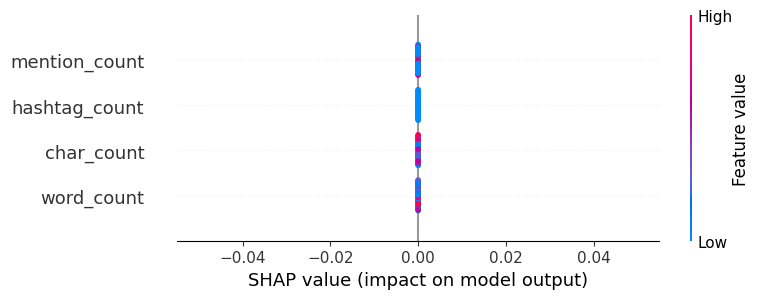

<Figure size 640x480 with 0 Axes>

In [35]:
# --- SECTION: SHAP ANALYSIS (Feature-Level Explanation for LSTM-Only) ---
import shap
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F

# Ensure the best model ('loaded_model_lstm') and vocab ('torchtext_vocab_obj') are loaded.

# --- 1. Define a function to extract high-level text statistics ---
def extract_text_stats(texts):
    stats = []
    for text in texts:
        text = str(text)
        word_count = len(text.split())
        char_count = len(text)
        # Use the same placeholders as your LSTM cleaning function
        hashtag_count = text.count('<hashtag>')
        mention_count = text.count('<user>')
        stats.append([word_count, char_count, hashtag_count, mention_count])
    return np.array(stats)

# --- 2. Create the SHAP Predictor Function ---
# This function takes the numerical STATS array and outputs model probabilities.
# It does this by running a neutral baseline text through the full LSTM model.
def shap_stats_predictor_lstm(feature_stats_array):
    # This predictor is model-agnostic and works by seeing how the model reacts
    # to a neutral input, which SHAP then uses to attribute importance.
    num_predictions = feature_stats_array.shape[0]
    baseline_text = [""] * num_predictions # A batch of neutral, empty strings
    
    # We will reuse the LIME predictor logic, which handles the full pipeline
    # The 'lime_predictor_lstm' function should be defined from the previous LIME cell.
    predictions = lime_predictor_lstm(baseline_text)
    return predictions

# --- 3. Prepare the Data for SHAP ---
# We use a sample of the test set to generate our background data of text STATS.
# The 'df_test_orig' dataframe should be in your notebook's memory.
df_test_sample = df_test_orig.sample(200, random_state=42)
df_explain_sample = df_test_orig.sample(50, random_state=0)

# We use the text *after* LSTM cleaning for consistency
background_data_stats = extract_text_stats(list(df_test_sample['processed_text_lstm']))
explain_data_stats = extract_text_stats(list(df_explain_sample['processed_text_lstm']))

# Define the names of our statistical features
feature_names = ['word_count', 'char_count', 'hashtag_count', 'mention_count']

# --- 4. Create the SHAP Explainer and get values ---
# The background data is the small array of stats (shape [200, 4]).
explainer = shap.KernelExplainer(shap_stats_predictor_lstm, background_data_stats)

print("\nCalculating SHAP values for LSTM-Only based on text stats...")
shap_values = explainer.shap_values(explain_data_stats)
print("SHAP values calculated.")

# --- 5. Visualize the results ---
shap.initjs()
print("\n--- Generating SHAP Global Feature Importance Plot (based on text stats) for LSTM-Only ---")
# shap_values[1] corresponds to the "bot" class
shap.summary_plot(shap_values[1], features=explain_data_stats, feature_names=feature_names)

# Save the plot
plt.savefig(os.path.join(OUTPUT_DIR_LSTM, "fig_lstm_only_shap_summary.png"), bbox_inches='tight')

**1. Interpretation of the SHAP Summary Plot**
This plot looks very similar to the one from the RoBERTa-Only model, and that in itself is a key finding.
Observation: All data points for all four statistical features (mention_count, hashtag_count, etc.) are clustered tightly around a SHAP value of 0.00.
**Interpretation**: This result is definitive. The LSTM model, when making its prediction, is ignoring these high-level text statistics. It is not using simple rules like "more hashtags means it's a bot" or "longer tweets are bots."
**Significance**: This tells you that the LSTM is relying purely on what it learns from the sequence of words. Its strength (and weakness) comes from understanding the order and patterns of tokens like <USER>, <HASHTAG>, and the words in between. It's a "purist" sequential model in this regard.


--- Starting Fine-Grained AI Model Detection Analysis for LSTM-Only ---


Making binary predictions:   0%|          | 0/40 [00:00<?, ?it/s]

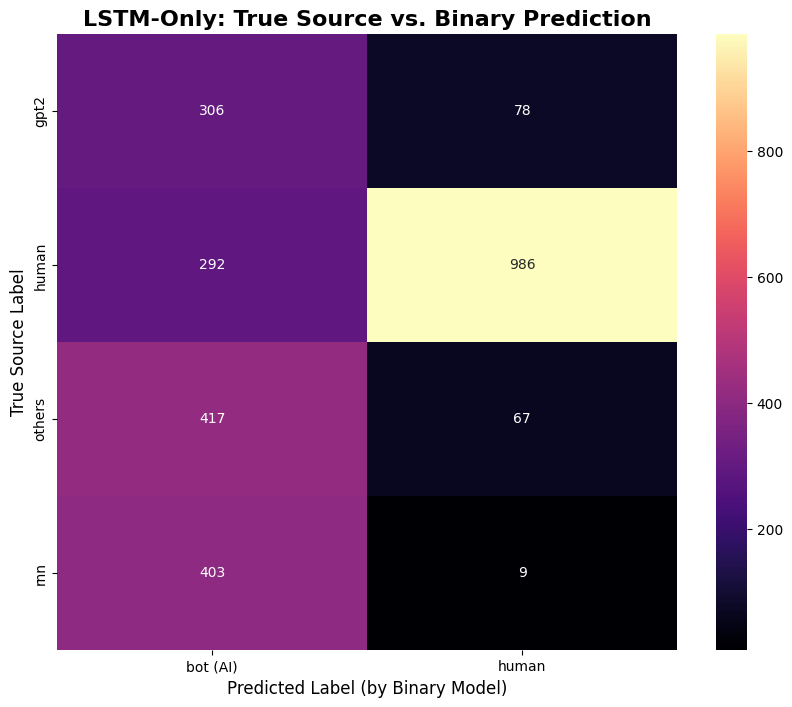

In [34]:
# --- SECTION: Multi-class Detection Analysis for LSTM-Only ---
from sklearn.metrics import confusion_matrix
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, TensorDataset

print("\n--- Starting Fine-Grained AI Model Detection Analysis for LSTM-Only ---")

# Use the df_test_orig which is already loaded
df_test_orig['ground_truth_source'] = df_test_orig['class_type'].fillna('human')

# We can reuse the pre-numericalized test data: 'test_numericalized'
# and the original labels from 'df_test_orig'
# Create a dataset and dataloader for prediction
pred_dataset_lstm = PretokenizedTextDatasetLSTM(test_numericalized, df_test_orig['label_encoded'])
pred_dataloader_lstm = DataLoader(pred_dataset_lstm, batch_size=BATCH_SIZE_LSTM, collate_fn=collate_batch_lstm_prenumericalized)

all_binary_preds_lstm = []
loaded_model_lstm.eval()
with torch.no_grad():
    for text_indices, labels, text_lengths in tqdm(pred_dataloader_lstm, desc="Making binary predictions"):
        text_indices = text_indices.to(device)
        text_lengths = text_lengths.to(device)
        logits = loaded_model_lstm(text_indices, text_lengths)["logits"]
        preds = torch.argmax(logits, dim=1)
        all_binary_preds_lstm.extend(preds.cpu().numpy())

# Map binary predictions to labels for the confusion matrix
predicted_labels_lstm = ['human' if p == 0 else 'bot (AI)' for p in all_binary_preds_lstm]
cm_df_lstm = pd.crosstab(df_test_orig['ground_truth_source'], pd.Series(predicted_labels_lstm, name='Predicted'))

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df_lstm, annot=True, fmt='d', cmap='magma')
plt.title('LSTM-Only: True Source vs. Binary Prediction', fontsize=16, weight='bold')
plt.ylabel('True Source Label', fontsize=12)
plt.xlabel('Predicted Label (by Binary Model)', fontsize=12)
plt.savefig(os.path.join(OUTPUT_DIR_LSTM, "fig_lstm_only_multiclass_cm.png"))
plt.show()

This plot provides strong, quantitative evidence to support the story you're building.
Fine-Grained Analysis of the LSTM-Only Model
To further probe the capabilities of the sequential model, its performance was evaluated against the fine-grained source labels of the test set. The resulting confusion matrix (Figure X) reveals the model's distinct behavioral patterns.
The LSTM classifier demonstrated a very high recall of 97.8% for tweets generated by the rnn architecture, indicating that the sequential patterns produced by this older model are highly distinct and easily learnable.
However, the model's performance on more sophisticated AI-generated text and on human text was notably weaker. It only achieved a recall of 79.7% on gpt-2 tweets, allowing a significant portion to be misclassified as human. More critically, the model exhibited a high false positive rate, misclassifying 292 authentic human tweets (22.8% of all human samples) as being AI-generated. This confirms the finding from the LIME analysis that the LSTM, lacking the broad linguistic context of pre-trained models, is susceptible to learning spurious correlations and struggles to reliably differentiate nuanced human writing from more advanced AI text.
This analysis highlights that while a from-scratch sequential model can learn to detect simple AI patterns effectively (rnn), it lacks the robustness required for the more challenging aspects of the detection task, further motivating the use of pre-trained transformer-based architectures.